In [9]:
a = sample_matrices(6)
print(a)
print(len(a))


[[[-1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1]]

 [[-1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1  1]]

 [[-1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1  1 -1]]

 ...

 [[ 1  1  1  1  1  1]
  [ 1  1  1  1  1  1]
  [ 1  1  1  1 -1  1]]

 [[ 1  1  1  1  1  1]
  [ 1  1  1  1  1  1]
  [ 1  1  1  1  1 -1]]

 [[ 1  1  1  1  1  1]
  [ 1  1  1  1  1  1]
  [ 1  1  1  1  1  1]]]
262144


In [100]:
import numpy as np
import matplotlib.pyplot as plt
from math import log2
from itertools import product
import time
plt.rc('text', usetex=False)

def total_matrices(d):
    """Generate all matrices A from {+-1}^{d/2 x d}. -- not tractable for large d"""
    rows = d // 2
    return np.array(list(product([-1, 1], repeat=rows * d))).reshape(-1, rows, d)

def sample_matrices(d):
    """Generate O(log d) matrices A from {+-1}^{d/2 x d}."""
    def sample_matrix(d):
        rows = d // 2 
        matrix = np.random.choice([-1, 1], size=(rows, d))
        return matrix
    
    samples = [sample_matrix(d) for i in range(int(10 * d**2))]
    return np.array(samples)

def random_convex_combination(A):
    """Choose a random vector in the convex combination of the rows of A."""
    rows = A.shape[0]
    weights = np.random.dirichlet(np.ones(rows))
    return np.dot(weights, A)

def gaussian_random_convex_combination(A):
    """Spherical random vector"""
    rows = A.shape[0]
    vector = np.random.normal(size=rows)
    vector /= np.linalg.norm(vector, ord=2)
    return np.dot(vector, A)

def random_row(A):
    rows = A.shape[0]
    ind = np.zeros(rows)
    ind[np.random.randint(rows)] = 1
    return np.dot(ind, A)

def count_matrices_containing_vector(matrices, target_vector):
    """Count the number of matrices A whose span contains the target vector."""
    count = 0
    
    for A in matrices:
        combined_matrix = np.vstack([A, np.expand_dims(target_vector, axis=0)])
        r1 = np.linalg.matrix_rank(A)
        r2 = np.linalg.matrix_rank(combined_matrix)
        if r1 == r2:
            count += 1
            
    return count

In [126]:
def results(dimensions):
    '''Count the number of matrices containing the target vector for each dimension.'''
    num_trials = 3 # 3 if using total_matrices

    row_counts = []
    conv_counts = []
    stds = []

    for d in dimensions:
        S = sample_matrices(d) # total_matrices

        row_curr = []
        conv_curr = []
        for i in range(num_trials):
            A = S[np.random.randint(S.shape[0])]

            c = gaussian_random_convex_combination(A) # added the gaussian_ tag
            conv_curr.append(count_matrices_containing_vector(S, c))

            r = random_row(A)
            row_curr.append(count_matrices_containing_vector(S, r))

        conv_counts.append(conv_curr)
        row_counts.append(row_curr)

        print(f"Dimension {d} : {np.mean(conv_counts[-1]) / int(10* d**2)}") # 2**(d * (d // 2))

    return row_counts, conv_counts

# Example usage
dimensions = [i for i in range(2, 50)]
row_counts, conv_counts = results(dimensions)

Dimension 2 : 0.4416666666666667
Dimension 3 : 0.2148148148148148
Dimension 4 : 0.025
Dimension 5 : 0.042666666666666665
Dimension 6 : 0.008333333333333333
Dimension 7 : 0.0020408163265306124
Dimension 8 : 0.0015625
Dimension 9 : 0.0012345679012345679
Dimension 10 : 0.001
Dimension 11 : 0.0008264462809917355
Dimension 12 : 0.0006944444444444445
Dimension 13 : 0.000591715976331361
Dimension 14 : 0.0005102040816326531
Dimension 15 : 0.00044444444444444447
Dimension 16 : 0.000390625
Dimension 17 : 0.00034602076124567473
Dimension 18 : 0.00030864197530864197
Dimension 19 : 0.0002770083102493075
Dimension 20 : 0.00025
Dimension 21 : 0.00022675736961451248
Dimension 22 : 0.00020661157024793388
Dimension 23 : 0.0001890359168241966
Dimension 24 : 0.00017361111111111112
Dimension 25 : 0.00016
Dimension 26 : 0.00014792899408284024
Dimension 27 : 0.00013717421124828533
Dimension 28 : 0.00012755102040816328
Dimension 29 : 0.00011890606420927467
Dimension 30 : 0.00011111111111111112
Dimension 31 : 

In [124]:

def plot_count_scale(dimensions, row_counts, conv_counts):
    # normalize counts -- for total_matrices
    # normalized_row_counts = [
    #     [c / 2**(d * (d // 2)) for c in cnt] \
    #         for d, cnt in zip(dimensions, row_counts)
    # ]
    # normalized_conv_counts = [
    #     [c / 2**(d * (d // 2)) for c in cnt] \
    #         for d, cnt in zip(dimensions, conv_counts)
    # ]

    # normalize counts -- for sample_matrices 
    normalized_row_counts = [
        [c / (int(10 * d**2)) for c in cnt] \
            for d, cnt in zip(dimensions, row_counts)
    ]
    normalized_conv_counts = [
        [c / int((10 * d**2)) for c in cnt] \
            for d, cnt in zip(dimensions, conv_counts)
    ]

    mean_row_counts = [log2(np.mean(cnt)) for cnt in normalized_row_counts]
    # std_row_counts = [np.std(cnt) for cnt in normalized_row_counts]
    mean_conv_counts = [log2(np.mean(cnt)) for cnt in normalized_conv_counts]
    # std_conv_counts = [np.mean(cnt) for cnt in normalized_conv_counts]
    
    # labels
    plt.xlabel('Dimension')
    plt.ylabel(r'$\log(\# / Total Matrices)$')
    plt.title(r'Fraction of matrices with $g$ in span')

    # plot showing how fraction decreases
    plt.errorbar(dimensions, mean_row_counts, fmt='o', color='black')
    plt.errorbar(dimensions, mean_conv_counts, fmt='^', color='red')
    # plt.errorbar(dimensions, mean_row_counts, yerr=std_row_counts, fmt='o', color='black')
    # plt.errorbar(dimensions, mean_conv_counts, yerr=std_conv_counts, fmt='^', color='red')

    # plot results
    plt.show()

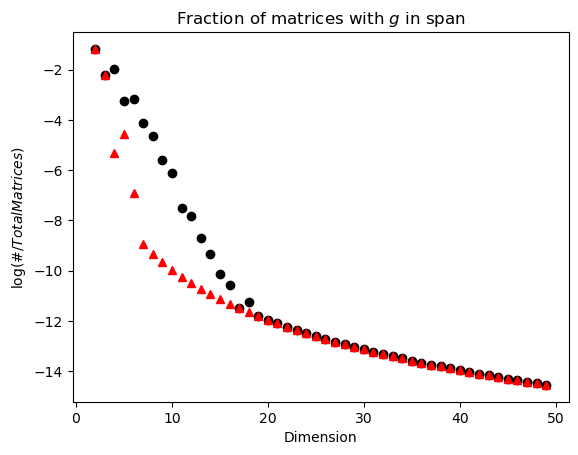

In [127]:
plot_count_scale(dimensions, row_counts, conv_counts)